In [1]:
import mne 
import numpy as np 
import matplotlib as plt

In [2]:
file_path = '/users/e4/E-2/DEAP_DATA/s10.dat'
data = np.fromfile(file_path, dtype=np.float32)

n_channels = 40
n_time_points = 8064
n_trials = len(data) // (n_channels * n_time_points)
data = data[:n_trials * n_channels * n_time_points].reshape(n_trials, n_channels, n_time_points)
subset = data[:10]
print (subset.shape)

(10, 40, 8064)


In [3]:
if np.isnan(subset).any() or np.isinf(subset).any():
    subset = np.nan_to_num(subset)
    print("NaNs or Infs found and replaced.")
else:
    print("No NaNs or Infs found.")

NaNs or Infs found and replaced.


In [4]:
subset_flattened = subset.reshape(n_channels, 10 * n_time_points)
info = mne.create_info(ch_names=[f'EEG {i+1}' for i in range(n_channels)], sfreq=128, ch_types='eeg')
raw = mne.io.RawArray(subset_flattened, info)
print(raw.info)

Creating RawArray with float64 data, n_channels=40, n_times=80640
    Range : 0 ... 80639 =      0.000 ...   629.992 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG 1, EEG 2, EEG 3, EEG 4, EEG 5, EEG 6, EEG 7, EEG 8, EEG 9, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 128.0 Hz
>


In [5]:
builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
for montage_name, montage_description in builtin_montages:
    print(f"{montage_name}: {montage_description}")

standard_1005: Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
standard_1020: Electrodes are named and positioned according to the international 10-20 system (94+3 locations)
standard_alphabetic: Electrodes are named with LETTER-NUMBER combinations (A1, B2, F4, …) (65+3 locations)
standard_postfixed: Electrodes are named according to the international 10-20 system using postfixes for intermediate positions (100+3 locations)
standard_prefixed: Electrodes are named according to the international 10-20 system using prefixes for intermediate positions (74+3 locations)
standard_primed: Electrodes are named according to the international 10-20 system using prime marks (' and '') for intermediate positions (100+3 locations)
biosemi16: BioSemi cap with 16 electrodes (16+3 locations)
biosemi32: BioSemi cap with 32 electrodes (32+3 locations)
biosemi64: BioSemi cap with 64 electrodes (64+3 locations)
biosemi128: BioSemi cap with 128 electrodes (1

In [6]:
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
print(easycap_montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 74 channels>


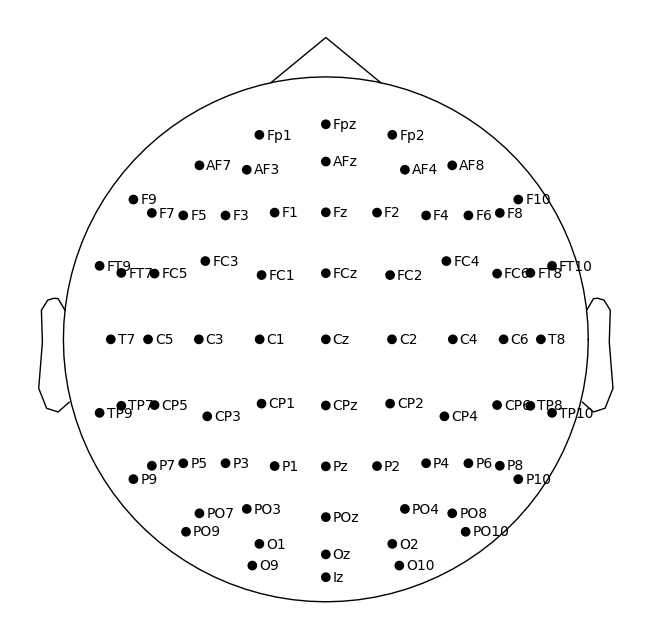

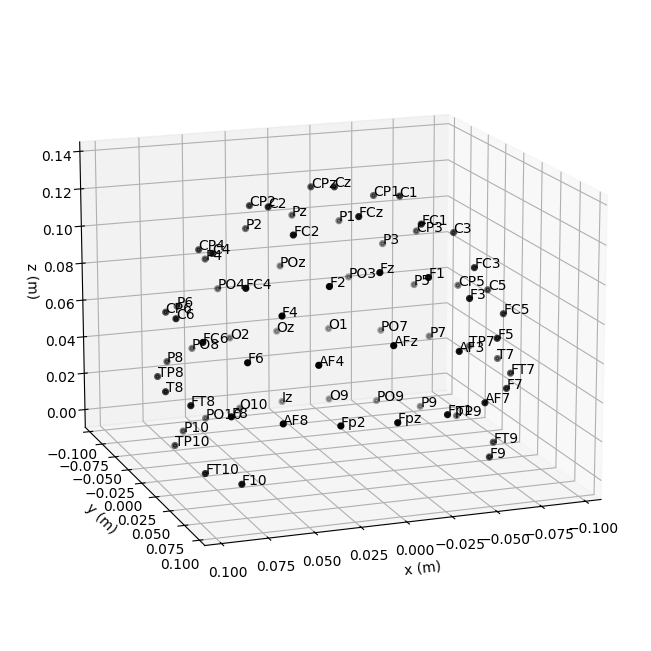

In [7]:
easycap_montage.plot()  
fig = easycap_montage.plot(kind="3d", show=False)  
fig = fig.gca().view_init(azim=70, elev=15)  

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


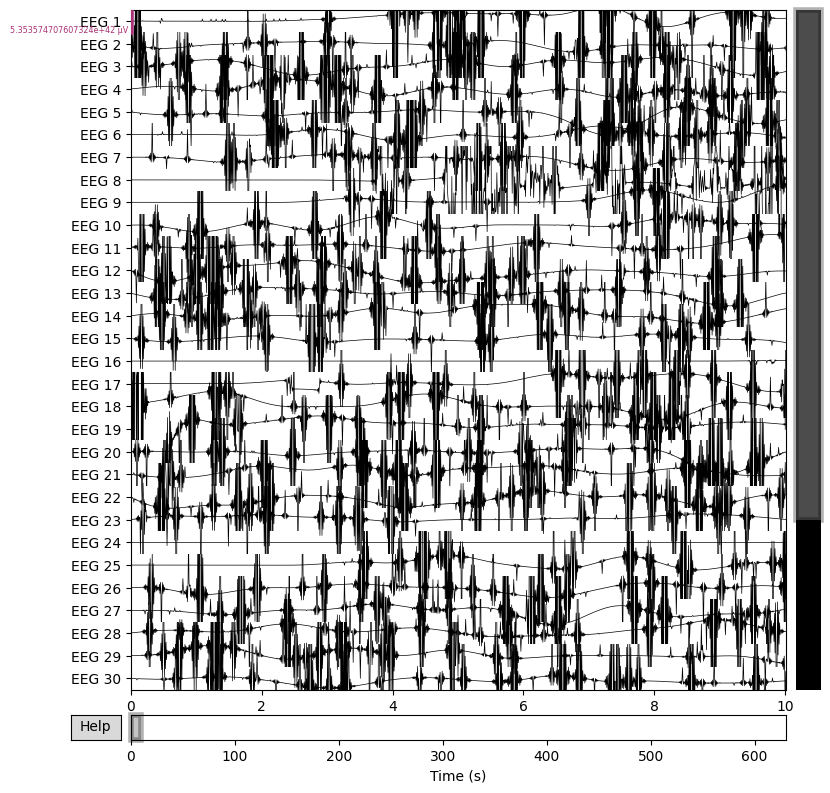

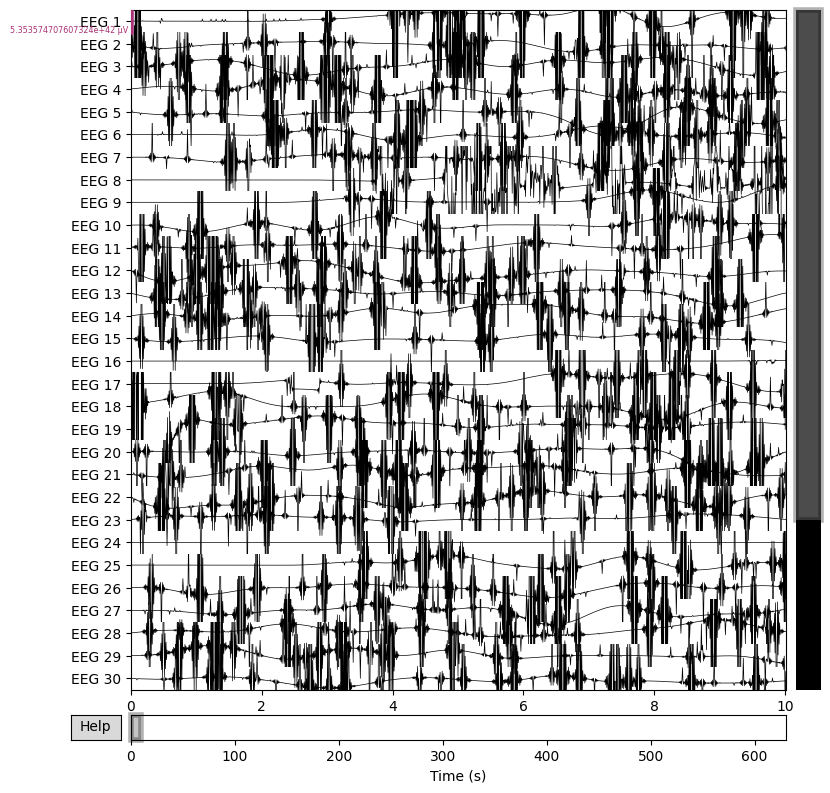

In [8]:
raw.filter(l_freq=1.0, h_freq=50.0, fir_design='firwin')
raw.plot(duration=10, n_channels=30, scalings='auto', title='Filtered DEAP Subset Data')

In [9]:
events = mne.find_events(raw, stim_channel="EEG 5")
print(events[:5])  # show the first 5

Trigger channel EEG 5 has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
[]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/event.py:502: RuntimeWarning: invalid value encountered in cast
  data = data.astype(np.int64)
/var/folders/sx/5hg33bqj785_0chtp8jbtxbw0000gn/T/ipykernel_32893/75256777.py:1: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(raw, stim_channel="EEG 5")


In [10]:
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

In [11]:
reject_criteria = dict(
    mag=4000e-15,  
    grad=4000e-13,  
    eeg=150e-6,  
    eog=250e-6,
)  

In [12]:
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)

ValueError: No matching events found for auditory/left (event id 1)

In [ ]:
conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(conds_we_care_about)  
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]
del raw, epochs  

In [ ]:
frequencies = np.arange(7, 30, 3)
power = aud_epochs.compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power.plot(["MEG 1332"])

In [ ]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(auditory=aud_evoked, visual=vis_evoked),
    legend="upper left",
    show_sensors="upper right",
)